In [17]:
from utils import compute_chunked_cosine_similarity
from dictionary_learning import CrossCoder
import pandas as pd
from huggingface_hub import hf_hub_download
import torch as th
import plotly.express as px
th.set_grad_enabled(False)

repo_id = "Butanium/max-activating-examples-gemma-2-2b-l13-mu4.1e-02-lr1e-04"
coder = CrossCoder.from_pretrained("Butanium/gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04", from_hub=True, device="cuda")
df_path = hf_hub_download(repo_id=repo_id, filename="feature_df.csv", repo_type="dataset")
df = pd.read_csv(df_path, index_col=0)

layer = 13
# filter for tag = IT only
only_it_feature_indices = th.tensor(df[df["tag"] == "IT only"].index.tolist())
# filter for tag = Base only
only_base_feature_indices = th.tensor(df[df["tag"] == "Base only"].index.tolist())
it_model_index = 1
base_model_index = 0

## IT-BASE

  0%|          | 0/31 [00:00<?, ?it/s]

found 167 features with cosine similarity > 0.9
IT only: 49685, Base: 37320, Cosine similarity: 0.9801746606826782
IT only: 50658, Base: 12123, Cosine similarity: 0.9762248992919922
IT only: 63438, Base: 30700, Cosine similarity: 0.9736478328704834
IT only: 22204, Base: 68712, Cosine similarity: 0.9733841419219971
IT only: 5358, Base: 46167, Cosine similarity: 0.96871417760849
IT only: 1105, Base: 18679, Cosine similarity: 0.968219518661499
IT only: 70022, Base: 61933, Cosine similarity: 0.966782808303833
IT only: 1105, Base: 66802, Cosine similarity: 0.9666922092437744
IT only: 37785, Base: 31071, Cosine similarity: 0.966456413269043
IT only: 67387, Base: 29178, Cosine similarity: 0.9647035002708435
IT only: 67387, Base: 18679, Cosine similarity: 0.9632608890533447
IT only: 73286, Base: 66802, Cosine similarity: 0.9628304243087769
IT only: 10186, Base: 26898, Cosine similarity: 0.9616096019744873
IT only: 29157, Base: 69715, Cosine similarity: 0.9613032341003418
IT only: 1105, Base: 2

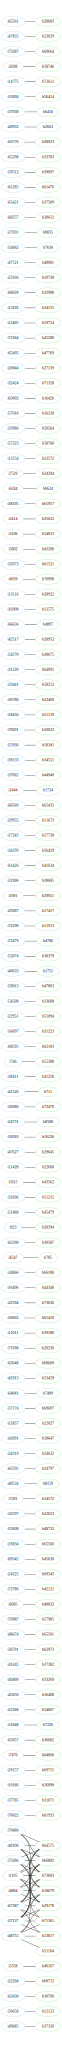

In [89]:
treshold = 0.9
# show heatmap with cosine between features from base and instruct
it_only_decoder_vec = coder.decoder.weight[it_model_index][only_it_feature_indices]
base_decoder_vec = coder.decoder.weight[base_model_index][only_base_feature_indices]
cos_sim_it_base = compute_chunked_cosine_similarity(
    it_only_decoder_vec, base_decoder_vec, 100
)
above_treshold_count = (cos_sim_it_base > treshold).sum(dim=1)

assert cos_sim_it_base.shape == (
    len(only_it_feature_indices),
    len(only_base_feature_indices),
)
fig = px.histogram(
    above_treshold_count.tolist(),
    title="Amount of Base features close to the IT only features",
    log_y=True,
    labels={"x": "Amount of similar base features", "y": "IT only feature count"},
)
fig.show()

above_treshold_base = (cos_sim_it_base > treshold).T.sum(dim=1)
fig = px.histogram(
    above_treshold_base.tolist(),
    title="Amount of IT only features close to the Base features",
    log_y=True,
    labels={"x": "Amount of similar IT only features", "y": "Base feature count"},
)
fig.show()

# Returns (row_indices, col_indices) sorted by values in descending order
treshold = 0.9
indicies = th.where(cos_sim_it_base > treshold)
sort_idx = th.argsort(cos_sim_it_base[cos_sim_it_base > treshold], descending=True)
row_idx = indicies[0][sort_idx]
col_idx = indicies[1][sort_idx]
print(f"found {len(row_idx)} features with cosine similarity > {treshold}")
for row, col in zip(row_idx, col_idx):
    print(
        f"IT only: {only_it_feature_indices[row]}, Base: {only_base_feature_indices[col]}, Cosine similarity: {cos_sim_it_base[row, col].item()}"
    )
# Create bipartite graph showing connections between IT and Base features
import networkx as nx
import matplotlib.pyplot as plt
from graphviz import Graph

# Create Graphviz graph
G = Graph(engine='dot')
G.attr(rankdir='LR')

# Create subgraphs for IT and Base nodes with same rank
with G.subgraph() as s:
    s.attr(rank='same')
    # Add IT nodes
    for i in list(dict.fromkeys(row_idx.tolist())):
        i = only_it_feature_indices[i]
        s.node(f"i{i}", f"i{i}", color="lightblue")

with G.subgraph() as s:
    s.attr(rank='same')
    # Add Base nodes  
    for i in list(dict.fromkeys(col_idx.tolist())):
        i = only_base_feature_indices[i]
        s.node(f"b{i}", f"b{i}", color="lightgreen")

# Add edges
for i, j in zip(row_idx.tolist(), col_idx.tolist()):
    i = only_it_feature_indices[i]
    j = only_base_feature_indices[j]
    G.edge(f"i{i}", f"b{j}")

# Render graph
# Render as SVG for vector graphics
G.format = 'svg'
G.render('feature_similarity_graph', view=False)

# Display SVG in notebook
from IPython.display import SVG
SVG('feature_similarity_graph.svg')


In [59]:
idc = only_it_feature_indices.tolist().index(49872)
cos_sim_it_base[idc].max()

tensor(0.3294)

In [5]:
it_with_base_sim = th.tensor(only_it_feature_indices)[row_idx.tolist()].tolist()
base_with_it_sim = th.tensor(only_base_feature_indices)[col_idx.tolist()].tolist()
it_df = df[df.index.isin(it_with_base_sim)]
with pd.option_context('display.max_rows', None):
    display(it_df.sort_values(by="base uselessness score", ascending=False))

,tag,dec_norm_diff,base uselessness score,fw_dead,fw_freq,lmsys_dead,lmsys_freq,freq,dead,avg_activation,lmsys_avg_activation,fw_avg_activation,dec_base_norm,dec_instruct_norm,dec_norm_diff.1,enc_instruct_norm,enc_norm_diff,dec_cos_sim,enc_cos_sim
16908,IT only,0.010779,9.524837,False,0.001969,False,0.010011,0.005576,False,1.839479,1.987754,1.226403,0.012657,0.587113,0.010779,1.573016,0.274364,0.508367,-0.487920
48755,IT only,0.019557,9.438097,False,0.000105,False,0.000460,0.000264,False,28.328539,30.297495,21.344910,0.036642,0.936803,0.019557,3.005430,0.191689,0.135528,-0.067738
23166,IT only,0.024087,6.304688,False,0.001164,False,0.000763,0.000985,False,4.426908,4.433992,4.423131,0.038287,0.794768,0.024087,1.636559,0.258843,0.689886,-0.128745
36780,IT only,0.025101,5.061709,False,0.001221,False,0.000724,0.000998,False,5.543407,4.708009,5.946370,0.042407,0.844741,0.025101,1.700668,0.240819,0.689356,-0.126031
67387,IT only,0.018806,4.711690,False,0.000115,False,0.000005,0.000065,False,93.111069,47.741074,94.731430,0.036602,0.973161,0.018806,2.307226,0.243280,0.282047,-0.093597
40106,IT only,0.017054,4.653867,False,0.000099,False,0.000466,0.000264,False,50.175571,54.245888,34.656963,0.030223,0.886085,0.017054,2.661207,0.186970,0.291483,-0.023108
37137,IT only,0.021317,4.125725,False,0.000114,False,0.000004,0.000065,False,31.680979,8.462041,32.292004,0.038808,0.910263,0.021317,2.050533,0.231212,0.352216,-0.027627
4884,IT only,0.020431,3.738317,False,0.000102,False,0.000514,0.000287,False,44.272724,51.109886,16.396393,0.038854,0.950874,0.020431,3.311990,0.186905,0.287521,-0.062463
65495,IT only,0.019780,3.118662,False,0.000349,False,0.000860,0.000578,False,5.858797,5.847269,5.881901,0.039882,1.008155,0.019780,1.509418,0.252975,0.611283,-0.097415
2698,IT only,0.016016,2.944769,False,0.000759,False,0.002593,0.001581,False,3.496258,3.733588,2.836520,0.029024,0.906121,0.016016,1.414363,0.258636,0.629286,-0.492733


## IT-IT

  0%|          | 0/317 [00:00<?, ?it/s]

found 3831 pairs with cosine similarity > 0.9 with 115 features
IT only 1: 46634, IT only 2: 22195, Cosine similarity: 0.9999996423721313
IT only 1: 34491, IT only 2: 22195, Cosine similarity: 0.9999992847442627
IT only 1: 46634, IT only 2: 34491, Cosine similarity: 0.9999988675117493
IT only 1: 57136, IT only 2: 53334, Cosine similarity: 0.9999986290931702
IT only 1: 34491, IT only 2: 20970, Cosine similarity: 0.9999985694885254
IT only 1: 53326, IT only 2: 31423, Cosine similarity: 0.9999984502792358
IT only 1: 22195, IT only 2: 20970, Cosine similarity: 0.9999982118606567
IT only 1: 53334, IT only 2: 1547, Cosine similarity: 0.9999980926513672
IT only 1: 35868, IT only 2: 20970, Cosine similarity: 0.9999980926513672
IT only 1: 46634, IT only 2: 20970, Cosine similarity: 0.999997615814209
IT only 1: 24336, IT only 2: 17371, Cosine similarity: 0.9999969005584717
IT only 1: 35868, IT only 2: 34491, Cosine similarity: 0.9999967813491821
IT only 1: 35868, IT only 2: 1547, Cosine similari

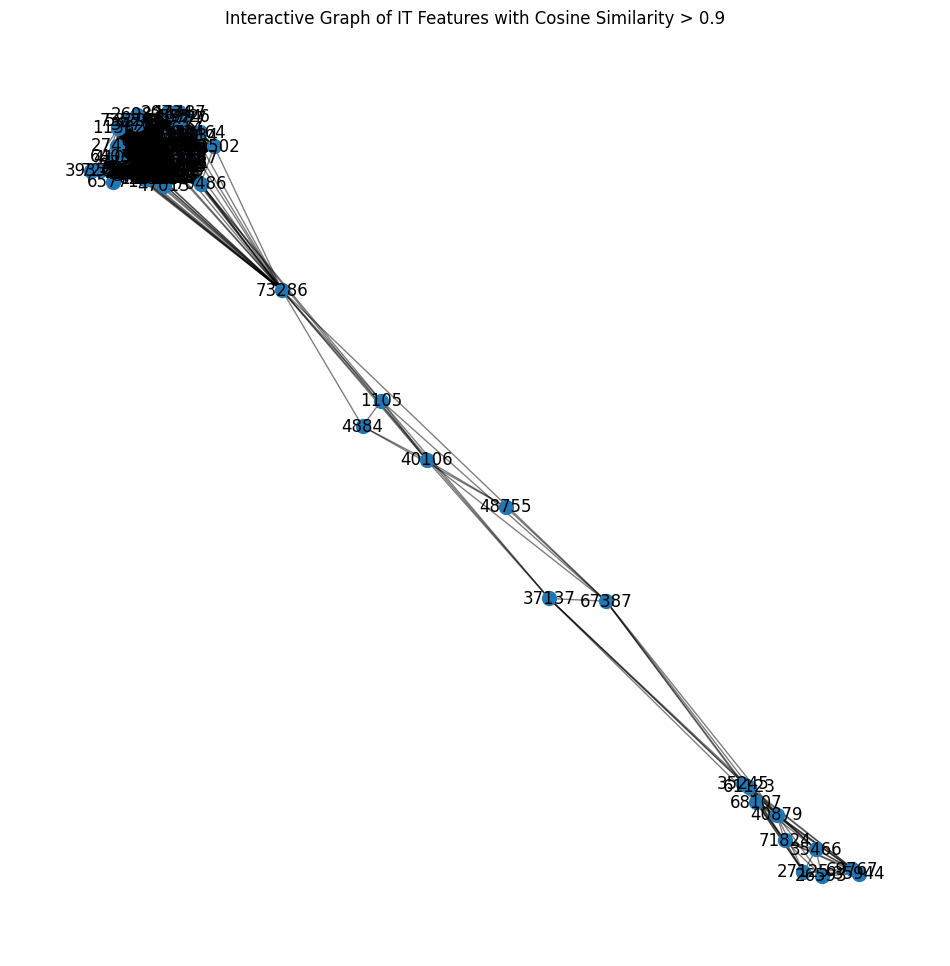

In [92]:
treshold = 0.9
# show heatmap with cosine between features from base and instruct
it_only_decoder_vec = coder.decoder.weight[it_model_index][only_it_feature_indices]
cos_sim_it_it = compute_chunked_cosine_similarity(
    it_only_decoder_vec, it_only_decoder_vec, 10
)
above_treshold_count = (cos_sim_it_it > treshold).sum(dim=1) - 1

assert cos_sim_it_it.shape == (
    len(only_it_feature_indices),
    len(only_it_feature_indices),
)
fig = px.histogram(
    above_treshold_count.tolist(),
    title="Amount of IT features close to the IT features",
    log_y=True,
    labels={"x": "Amount of similar IT features", "y": "IT feature count"},
)
fig.show()
treshold = 0.9
mask = (cos_sim_it_it > treshold) & ~(th.eye(cos_sim_it_it.shape[0], dtype=th.bool))
indicies = th.where(mask)
sort_idx = th.argsort(cos_sim_it_it[mask], descending=True)
row_idx = indicies[0][sort_idx]
col_idx = indicies[1][sort_idx]
print(f"found {len(row_idx) // 2} pairs with cosine similarity > {treshold} with {len(set(row_idx.tolist()) | set(col_idx.tolist()))} features")
for row, col in zip(row_idx, col_idx):
    assert row != col
    if row > col:
        print(
            f"IT only 1: {only_it_feature_indices[row]}, IT only 2: {only_it_feature_indices[col]}, Cosine similarity: {cos_sim_it_it[row, col].item()}"
        )

import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor

# Create a graph
G = nx.Graph()

# Add edges for cosine similarity greater than 0.9
for row, col in zip(row_idx, col_idx):
    if cos_sim_it_it[row, col].item() > 0.9:
        G.add_edge(only_it_feature_indices[row].item(), only_it_feature_indices[col].item(), weight=cos_sim_it_it[row, col].item())

# Draw the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.001)  # positions for all nodes
nx.draw_networkx_nodes(G, pos, node_size=100)
nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=12)

# Add interactive cursor

plt.title("Interactive Graph of IT Features with Cosine Similarity > 0.9")
plt.axis('off')  # Turn off the axis
plt.show()


In [41]:
features = list(set(row_idx.tolist()) | set(col_idx.tolist()))
features_idx = only_it_feature_indices[features]
# display the feature df for these features

df[df.index.isin(features_idx.tolist())].sort_values(by="base uselessness score", ascending=False)


,tag,dec_norm_diff,base uselessness score,fw_dead,fw_freq,lmsys_dead,lmsys_freq,freq,dead,avg_activation,lmsys_avg_activation,fw_avg_activation,dec_base_norm,dec_instruct_norm,dec_norm_diff.1,enc_instruct_norm,enc_norm_diff,dec_cos_sim,enc_cos_sim
48755,IT only,0.019557,9.438097,False,1.054571e-04,False,4.599102e-04,2.644355e-04,False,28.328539,30.297495,21.344910,0.036642,0.936803,0.019557,3.005430,0.191689,0.135528,-0.067738
73286,IT only,0.011435,7.611642,False,3.654529e-04,False,1.283926e-03,7.774042e-04,False,16.772169,17.307016,15.243952,0.013787,0.602868,0.011435,1.981996,0.243725,0.420231,0.032037
68539,IT only,0.003428,7.374784,False,7.280427e-04,False,2.853253e-03,1.681237e-03,False,4.531375,4.548746,4.476009,0.001968,0.287068,0.003428,0.546112,0.297999,0.492514,0.085050
27494,IT only,0.004862,7.053835,False,5.373746e-04,False,2.515299e-03,1.424508e-03,False,1.866859,1.706317,2.478008,0.002568,0.264107,0.004862,0.507652,0.341313,0.556114,0.106789
31423,IT only,0.002924,6.976157,False,7.743294e-04,False,2.914273e-03,1.734131e-03,False,9.396894,9.660297,8.590637,0.001789,0.305952,0.002924,0.572990,0.283607,0.464005,0.053758
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71456,IT only,0.040323,-0.000000,True,0.000000e+00,True,0.000000e+00,0.000000e+00,True,NaN,NaN,NaN,0.005577,0.069154,0.040323,0.186908,0.432874,0.111286,0.208028
73524,IT only,0.011913,-0.000000,True,0.000000e+00,True,0.000000e+00,0.000000e+00,True,NaN,NaN,NaN,0.001944,0.081587,0.011913,0.206286,0.395327,0.168691,0.175323
56084,IT only,0.004441,-0.054710,False,6.816880e-08,True,0.000000e+00,3.759390e-08,False,NaN,NaN,0.009378,0.002041,0.229784,0.004441,0.466308,0.367979,0.500975,0.148934
44702,IT only,0.048396,-0.196118,False,3.408440e-07,False,1.676363e-07,2.631573e-07,False,0.175276,0.067685,0.218313,0.028856,0.298126,0.048396,0.881470,0.431833,0.501266,0.024413


## IT - rest

In [60]:
cosim_it_all = compute_chunked_cosine_similarity(it_only_decoder_vec, coder.decoder.weight[base_model_index], 4)

  0%|          | 0/794 [00:00<?, ?it/s]

found 782 features with cosine similarity > 0.9


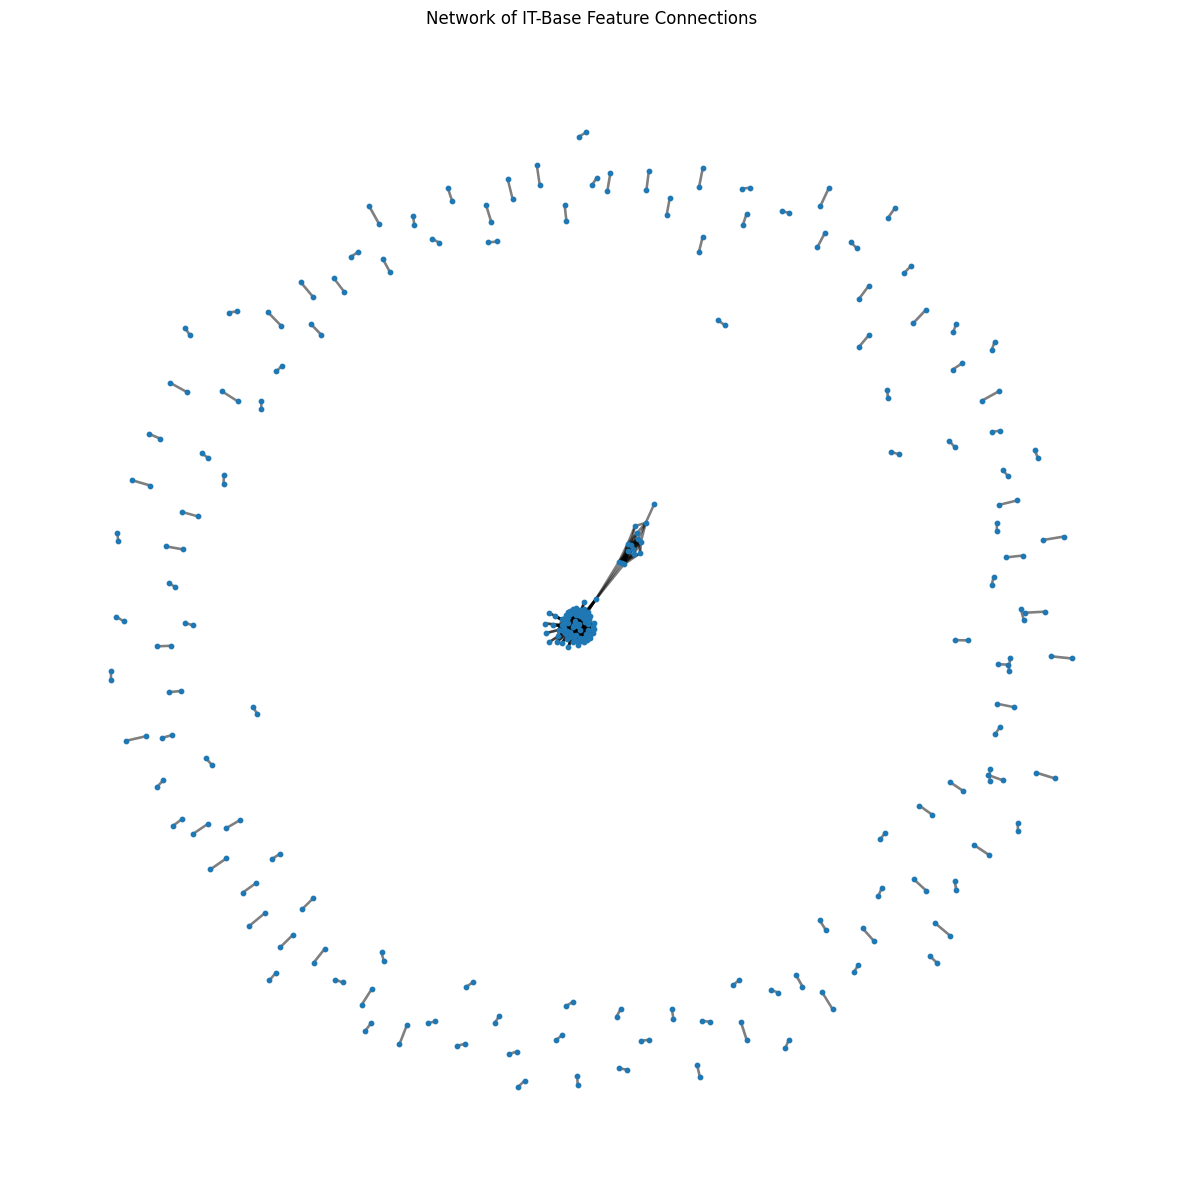

In [100]:
above_treshold_count = (cosim_it_all > treshold).sum(dim=1)

assert cos_sim_it_base.shape == (
    len(only_it_feature_indices),
    len(only_base_feature_indices),
)
fig = px.histogram(
    above_treshold_count.tolist(),
    title="Amount of features close to the IT only features",
    log_y=True,
    labels={"x": "Amount of similar features", "y": "Count"},
)
fig.show()
# Create network graph of IT-base feature connections above threshold
G_it_base = nx.Graph()


# Add edges where cosine similarity is above threshold
indicies = th.where((cosim_it_all > treshold))
row_idx = indicies[0]
col_idx = indicies[1]
print(f"found {len(row_idx)} feature pairs with cosine similarity > {treshold}")
for row, col in zip(row_idx, col_idx):
    if only_it_feature_indices[row].item() != col.item():
        G_it_base.add_edge(only_it_feature_indices[row].item(), col.item(), weight=cosim_it_all[row, col].item())

# Draw the graph
plt.figure(figsize=(15, 15))
pos = nx.spring_layout(G_it_base)
# Draw nodes
nx.draw_networkx_nodes(G_it_base, pos, node_size=10)

# Draw edges with width proportional to weight 
edge_weights = [G_it_base[u][v]['weight'] for u,v in G_it_base.edges()]
nx.draw_networkx_edges(G_it_base, pos, width=[w*2 for w in edge_weights], alpha=0.5)

plt.title("Network of IT-Base Feature Connections")
plt.axis('off')
plt.show()


## suspicious features

In [9]:
suspicious_features = [ 5146,  9990, 14401, 15873, 15956, 16496, 21742, 25687, 26568, 29333,
       31378, 34266, 34866, 41526, 42498, 43304, 48194, 52053, 59512, 69064,
       73650]
# check for intersection with it_with_base_sim
print(set(suspicious_features) & set(it_with_base_sim))
# for each suspicious feature, print the cosine similarity to the closest base feature
cosine_similarities = []
for feature in suspicious_features:
    id_in_list = only_it_feature_indices.index(feature)
    similarity = cos_sim_it_base[id_in_list, th.argmax(cos_sim_it_base[id_in_list])].item()
    cosine_similarities.append((feature, similarity))

# Sort by cosine similarity in descending order
cosine_similarities.sort(key=lambda x: x[1], reverse=True)

# Print the results
for feature, similarity in cosine_similarities:
    print(f"Suspicious feature: {feature}, Cosine similarity to closest base feature: {similarity}")


{16496, 34866, 59512, 41526}
Suspicious feature: 16496, Cosine similarity to closest base feature: 0.9450858235359192
Suspicious feature: 34866, Cosine similarity to closest base feature: 0.9450819492340088
Suspicious feature: 41526, Cosine similarity to closest base feature: 0.9399175047874451
Suspicious feature: 59512, Cosine similarity to closest base feature: 0.9071714878082275
Suspicious feature: 34266, Cosine similarity to closest base feature: 0.8821802735328674
Suspicious feature: 15956, Cosine similarity to closest base feature: 0.8266763687133789
Suspicious feature: 9990, Cosine similarity to closest base feature: 0.814885675907135
Suspicious feature: 42498, Cosine similarity to closest base feature: 0.7077487707138062
Suspicious feature: 29333, Cosine similarity to closest base feature: 0.6618666052818298
Suspicious feature: 48194, Cosine similarity to closest base feature: 0.6439493298530579
Suspicious feature: 14401, Cosine similarity to closest base feature: 0.64280861616